# IMPORT

In [ ]:
!%%bash

!pip install --upgrade pip
!pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab,ocr]

# For Colab/linux based machines:
!wget https://dl.xpdfreader.com/xpdf-tools-linux-4.04.tar.gz
!tar -xvf xpdf-tools-linux-4.04.tar.gz && sudo cp xpdf-tools-linux-4.04/bin64/pdftotext /usr/local/bin

/bin/bash: line 0: fg: no job control
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
DEPRECATION: git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab,ocr] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-install-xhep3f2z/farm-haystack_d902e9d9e15a4a668ae9e1b167ddb26c
  Running command git clone --filter=blob:none --quiet https://github.com/deep

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 612.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 9.3 MB/s eta 0:00:00


In [ ]:
import logging
import sys
from textwrap import TextWrapper

import datasets
import huggingface_hub
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import torch
import transformers
from IPython.display import set_matplotlib_formats

# TODO: Consider adding SageMaker StudioLab
is_colab = "google.colab" in sys.modules
is_kaggle = "kaggle_secrets" in sys.modules
is_gpu_available = torch.cuda.is_available()

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("piaf")
print(dataset)
dataset = {split: dset.to_pandas() for split, dset in dataset.flatten().items()}

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3835 [00:00<?, ? examples/s]

Dataset piaf downloaded and prepared to /root/.cache/huggingface/datasets/piaf/plain_text/1.0.0/535c60f4155fe1d644c1746e86131963c082f309d0dbb5ba4d606786c7f4a6ae. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 3835
    })
})


# Create RETRIEVER

In [ ]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

# Alternative if Docker is installed
from haystack.utils import launch_es

launch_es()

!curl -X GET "localhost:9200/?pretty"

from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(return_embedding=True)

# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")

for split, df in dataset.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], "id": row["id"],"title": row["title"]} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

{
  "name" : "05426a32e28b",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "EprKu-v-RnyYbwzbOJx8Mw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}
Loaded 761 documents


# CREATE READER

In [ ]:
from haystack.nodes import FARMReader

model_ckpt = "etalab-ia/camembert-base-squadFR-fquad-piaf" #alternative larger models: deepset/roberta-base-squad2-distilled or deepset/xlm-roberta-large-squad2 or the tiny distilled model: deepset/tinyroberta-squad2
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

print(reader.predict_on_texts(question="Quel est la capitale de la france ?", texts=["La capitale est Paris."], top_k=1))

/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


{'query': 'Quel est la capitale de la france ?', 'no_ans_gap': 24.096153259277344, 'answers': [<Answer {'answer': 'Paris', 'type': 'extractive', 'score': 0.9624673128128052, 'context': 'La capitale est Paris.', 'offsets_in_document': [{'start': 16, 'end': 21}], 'offsets_in_context': [{'start': 16, 'end': 21}], 'document_ids': ['9f9a6d2feaa37c8402d17866c0a6ce14'], 'meta': {}}>]}


# TEST Retriever

## Setup Dataset and Retriever

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("piaf")
print(dataset)

dataset = {split: dset.to_pandas() for split, dset in dataset.flatten().items()}
dataset = {'train': dataset['train'].iloc[:len(dataset['train']) * 4 //5], 'test': dataset['train'].iloc[len(dataset['train']) * 4//5:]}

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 3835
    })
})


In [ ]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

# Alternative if Docker is installed
from haystack.utils import launch_es

launch_es()

!curl -X GET "localhost:9200/?pretty"

from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(return_embedding=True)

# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")

for split, df in dataset.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], "id": row["id"],"title": row["title"]} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

{
  "name" : "05426a32e28b",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "EprKu-v-RnyYbwzbOJx8Mw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}
Loaded 762 documents


In [ ]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [ ]:
from haystack import Label, Answer, Document

labels = []
for i, row in dataset["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["id"]),
                is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})  
        labels.append(label)

## Evaluation

766


/usr/local/lib/python3.9/dist-packages/haystack/schema.py:1377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.9/dist-packages/haystack/schema.py:1377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.9/dist-packages/haystack/schema.py:1377: SettingWithCopyWarning: 
A value is trying to be set on a copy

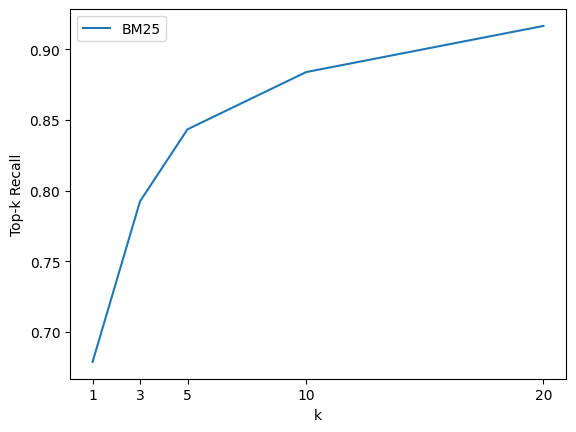

In [ ]:
document_store.write_labels(labels, index="label")
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in topk_values:        
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(bm25_retriever)

def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([bm25_topk_df], ["BM25"])

# Test Reader

In [ ]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


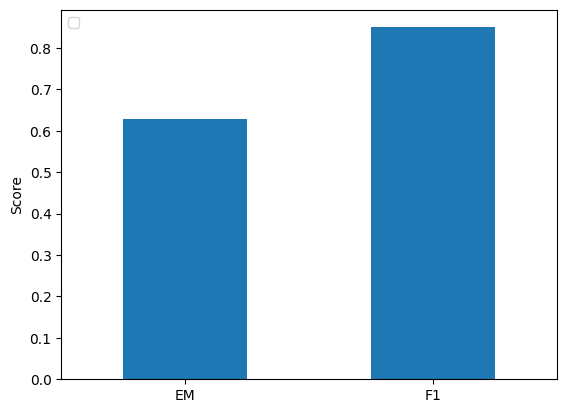

In [ ]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

from haystack.nodes import FARMReader

model_ckpt = "etalab-ia/camembert-base-squadFR-fquad-piaf" #alternative larger models: deepset/roberta-base-squad2-distilled or deepset/xlm-roberta-large-squad2 or the tiny distilled model: deepset/tinyroberta-squad2
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

reader_eval = {}
reader_eval[""] = evaluate_reader(reader)

def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)